## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import sys
import os

sys.path.append(os.path.abspath(".."))
from src.utils import read_config,plot_correlation_matrix,plot_distribution,box_plot,scatter_plot,plot_dendrogram,plot_elbow

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
#import kmeans 
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', None)

## Explore Data

In [2]:
config = read_config()
segmentation_path = os.path.join(os.getcwd(),"..","Data" ,config["filenames"]["segmentation"])
df = pd.read_csv(segmentation_path, index_col=0)
df.head()


c:\Users\satwik.boina\Documents\git_clones\CustomerAnalytics\src\..


,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


- We don't need ID for modelling
- Age and Income should be scaled to ignore the bias 
- Occupation, Education and Settlement size are Ordinal categorical variables
- Marital Status and Sex are Binary categorical variables.

In [3]:
df.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


In [4]:
df.isna().sum()

Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

### Plotting

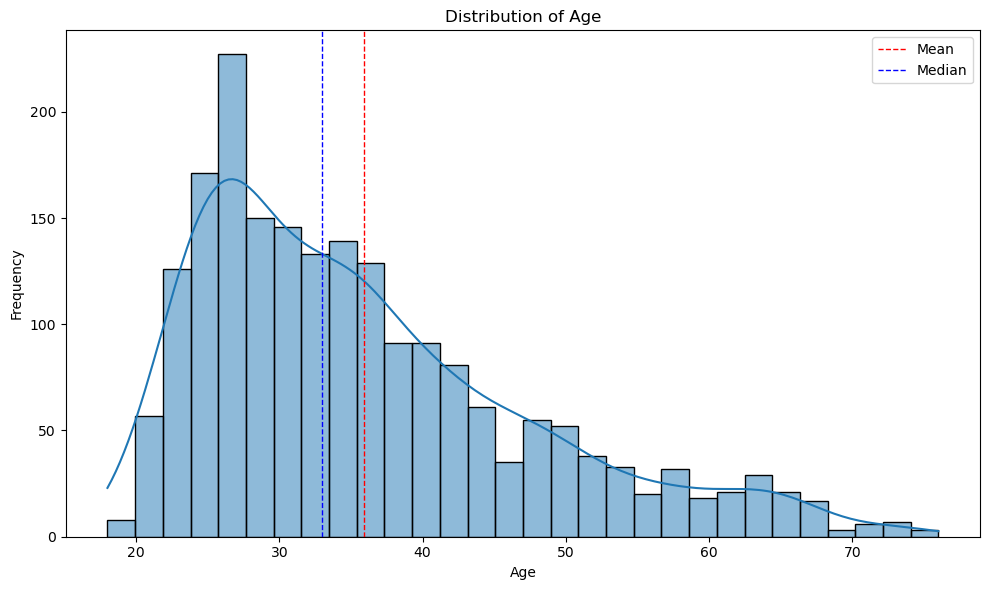

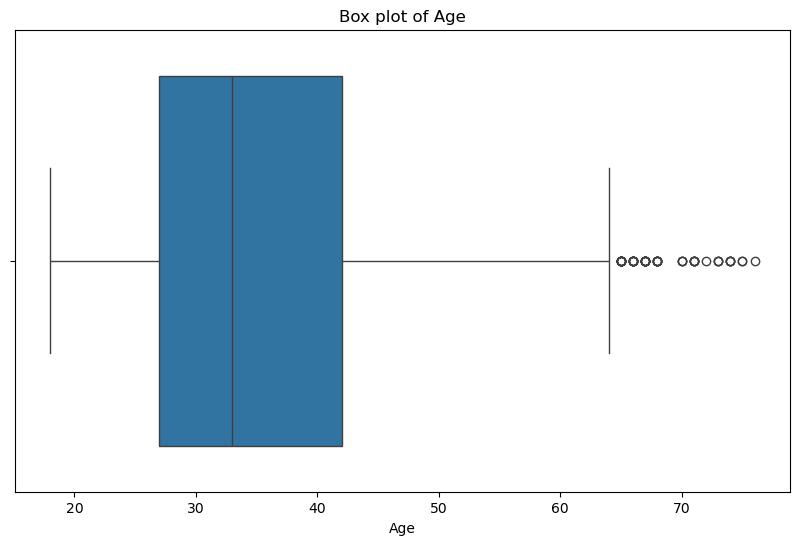

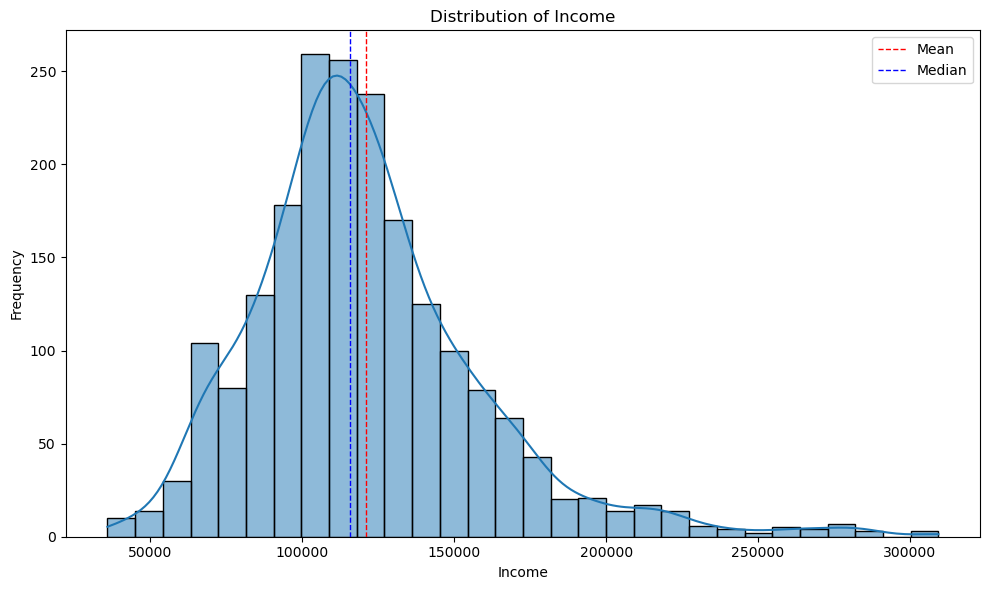

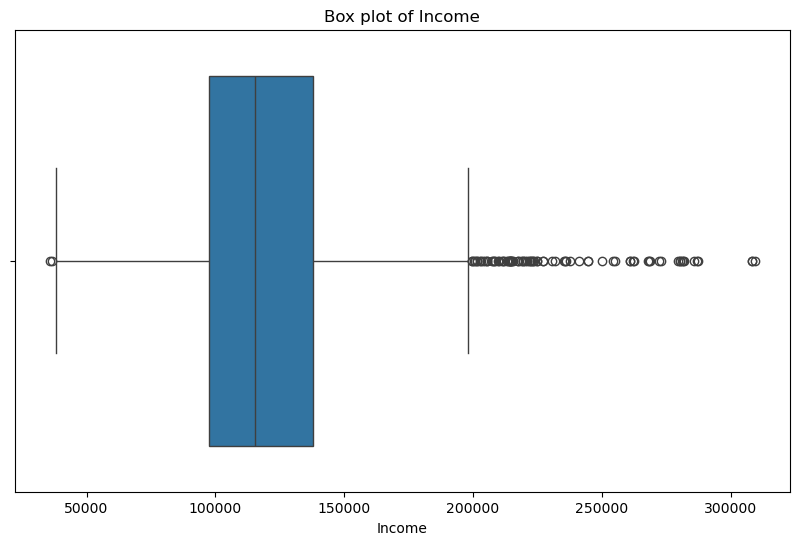

In [5]:
univariate_cols = ["Age","Income"]
for col in univariate_cols:
    plot_distribution(df, col, title=f"Distribution of {col}")
    box_plot(df, col, title=f"Box plot of {col}")


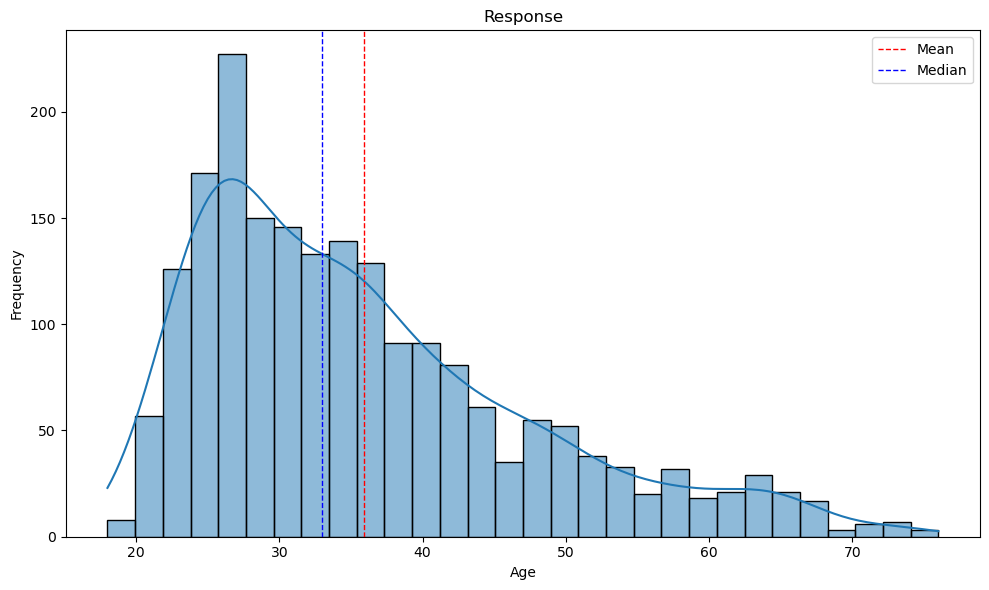

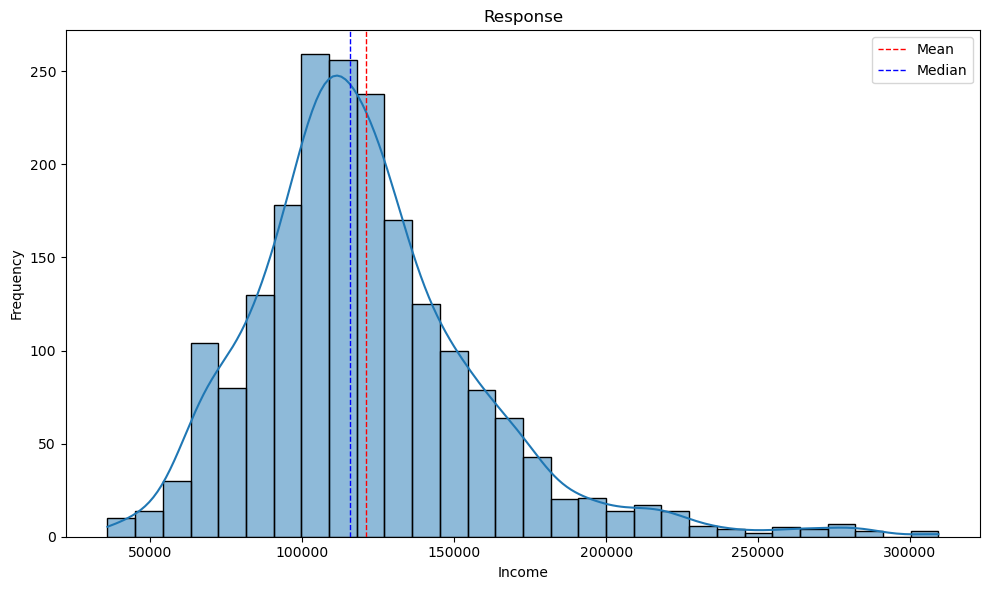

In [6]:
plot_distribution(df, "Age", "Response")
plot_distribution(df, "Income", "Response")

- Age is right skewed which means the dataset has a lot of young customers.
- Income is almost normal except some slight skewness towards right.
- Mean and Median of income is pretty close.

c:\Users\satwik.boina\Documents\git_clones\CustomerAnalytics\src\utils.py:137: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=x_column, y=y_column,hue= hue, palette='viridis')


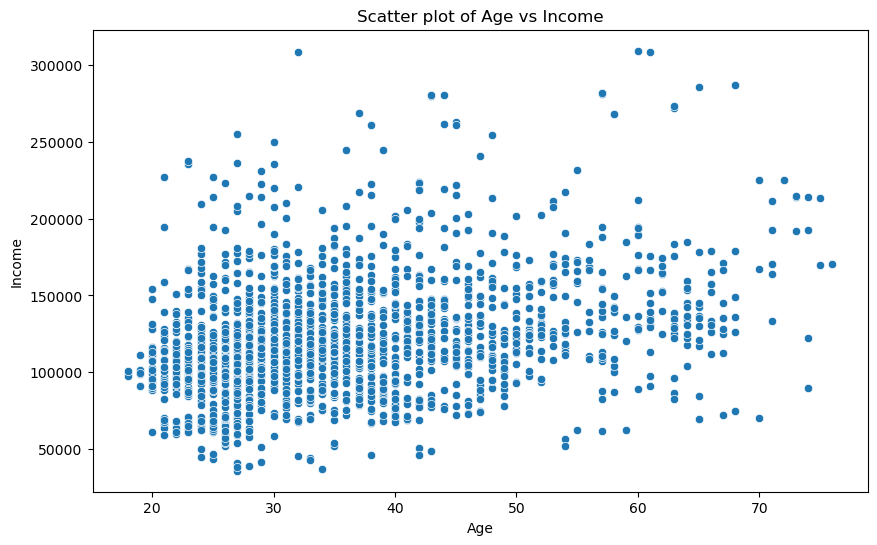

In [7]:
scatter_plot_pairs = [("Age", "Income")]

for x, y in scatter_plot_pairs:
    scatter_plot(df, x, y, title=f"Scatter plot of {x} vs {y}")

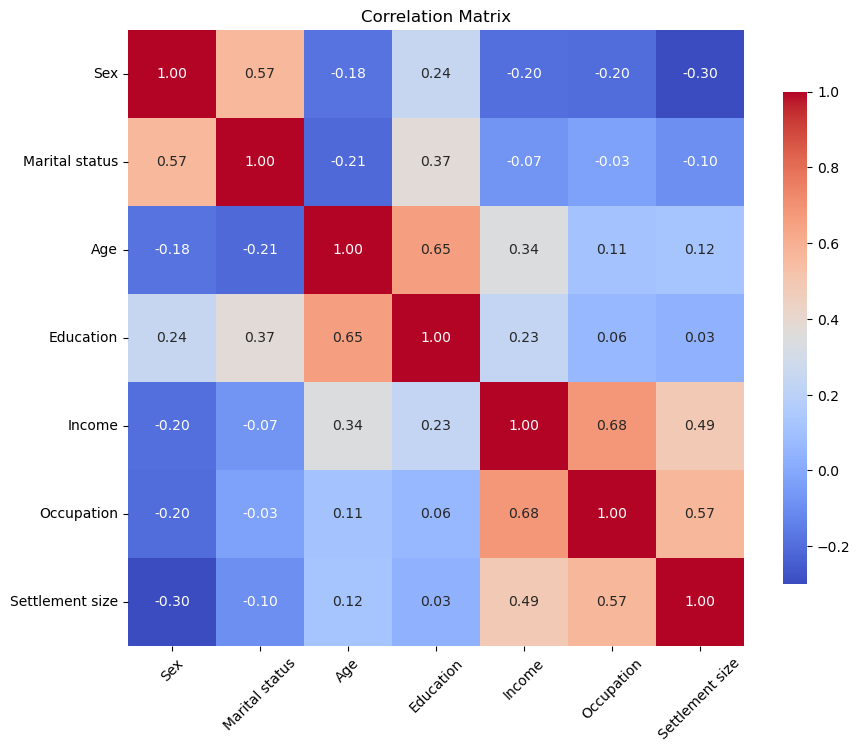

In [8]:
plot_correlation_matrix(df, title="Correlation Matrix")

- High correlation between Age and Education, Occupation and Income

## Standardization of Age and Income

In [9]:
scaler = StandardScaler()
cols_to_scale = ["Age", "Income"]
columns = df.columns.tolist()
# but we will scale all columns for consistency
data = scaler.fit_transform(df)


## Hierarchical Clustering

## Ward’s Linkage:
Ward’s linkage merges clusters to minimize the increase in total within-cluster variance (or error sum of squares).

In other words, at each step, it chooses the merge that causes the smallest increase in variance of the combined cluster.

This method focuses on keeping clusters as compact and homogeneous as possible.

In [10]:
clusters = linkage(data, method='ward')


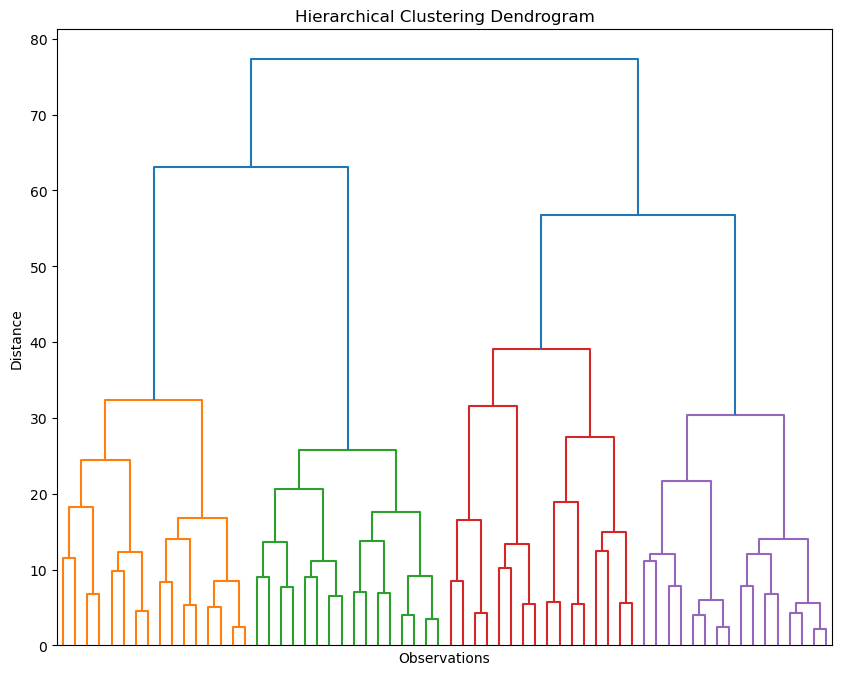

In [11]:
plot_dendrogram(clusters, levels=5)

Longest vertical line which is not intercepted by the horizontal line.

We can start with the Hierarchical clustering to decide upon the number of clusters.

In [12]:
number_of_clusters = clusters.shape[-1]
print(f"Number of clusters from hierarchical clustering: {number_of_clusters}")

Number of clusters from hierarchical clustering: 4


## K means Clustering

- Initialize with best possible centroids.
- try to identify the best cluster count using the elbow method by inspecing the plot of wcss.

In [13]:
wcss = []

for i in range(1,11,1):
    kmeans = KMeans(n_clusters=i,init="k-means++", random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
    # inertia is the sum of squared distances of samples to their closest cluster center



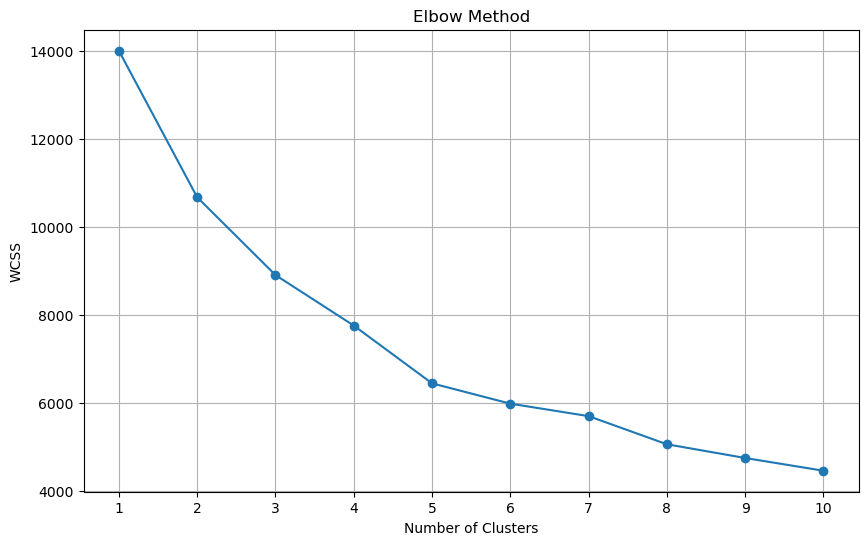

In [14]:
plot_elbow(wcss = wcss)

In [15]:
kmeans = KMeans(n_clusters=5, init="k-means++", random_state=42)
kmeans.fit(data)

KMeans(n_clusters=5, random_state=42)

In [16]:
df_segmented = df.copy()
df_segmented["Cluster"] = kmeans.labels_

segment_analysis = df_segmented.groupby("Cluster").mean()
segment_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Cluster,,,,,,,
0,0.028302,0.000000,35.418239,0.619497,100066.210692,0.393082,0.110063
1,0.891705,0.652074,33.297235,1.108295,89360.076037,0.094470,0.000000
2,0.748582,0.979206,27.924386,1.003781,119900.778828,1.052930,0.814745
3,0.004264,0.044776,37.142857,0.710021,144048.624733,1.283582,1.539446
4,0.480000,0.684000,55.648000,2.136000,161276.772000,1.184000,1.160000


In [17]:
segment_analysis['k_obs'] = df_segmented.groupby(["Cluster"])['Sex'].count()
segment_analysis['prop_obs'] = segment_analysis["k_obs"]/segment_analysis["k_obs"].sum()
segment_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,k_obs,prop_obs
Cluster,,,,,,,,,
0,0.028302,0.000000,35.418239,0.619497,100066.210692,0.393082,0.110063,318,0.1590
1,0.891705,0.652074,33.297235,1.108295,89360.076037,0.094470,0.000000,434,0.2170
2,0.748582,0.979206,27.924386,1.003781,119900.778828,1.052930,0.814745,529,0.2645
3,0.004264,0.044776,37.142857,0.710021,144048.624733,1.283582,1.539446,469,0.2345
4,0.480000,0.684000,55.648000,2.136000,161276.772000,1.184000,1.160000,250,0.1250


- Cluster 0 : Men who are unmarried stands out
- Cluster 1 : Women who are married but unemployed
- Cluster 2 : Standard 
- Cluster 3 : Does well in Occupation and Income
- Cluster 4 : Education and income are above par

In [18]:
cluster_renaming = {
    0 : "Unmarried Men",
    1 : "Typical Women",
    2 : "Standard",
    3 : "Career Focussed",
    4 : "Well off"
}
segment_analysis = segment_analysis.reset_index()
segment_analysis['Cluster_Description'] = segment_analysis['Cluster'].map(cluster_renaming)
segment_analysis

,Cluster,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,k_obs,prop_obs,Cluster_Description
0,0,0.028302,0.000000,35.418239,0.619497,100066.210692,0.393082,0.110063,318,0.1590,Unmarried Men
1,1,0.891705,0.652074,33.297235,1.108295,89360.076037,0.094470,0.000000,434,0.2170,Typical Women
2,2,0.748582,0.979206,27.924386,1.003781,119900.778828,1.052930,0.814745,529,0.2645,Standard
3,3,0.004264,0.044776,37.142857,0.710021,144048.624733,1.283582,1.539446,469,0.2345,Career Focussed
4,4,0.480000,0.684000,55.648000,2.136000,161276.772000,1.184000,1.160000,250,0.1250,Well off


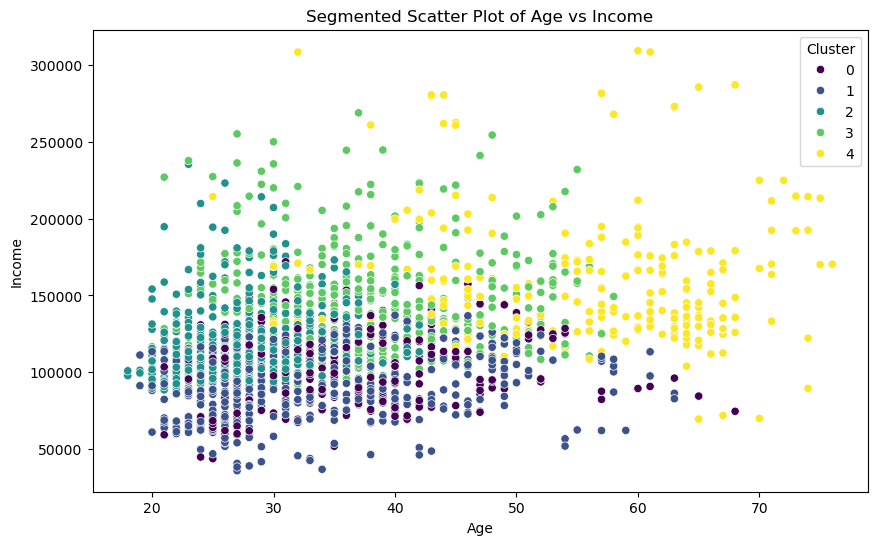

In [19]:
scatter_plot(df_segmented, "Age", "Income", hue="Cluster", title="Segmented Scatter Plot of Age vs Income")

Did a decent job but can be improved by reducing some dimensions